In [1]:
from dataclasses import dataclass
import glob
import os
from typing import Dict, List, Optional, Sequence
import imageio_ffmpeg
import matplotlib.pyplot as plt
import numpy as np
import torch

In [15]:
# ==== 配置区 ====
HEATMAP_DIR = "/data02/henry/wan_cache/attn_heatmaps"
STEP = 0  # step_idx，对应 stepXXX 的 XXX
PATCH_SIZE = (1, 2, 2)  # (t_patch, h_patch, w_patch)

# 维度聚合
TOKEN_GROUP: Optional[List[int]] = None  # e.g., [321, 322] 表示把这两个 token 聚合
# TOKEN_GROUP = list(token_map.keys())
TOKEN_REDUCTION = "mean"  # 对一个 block 内多个 token 先做 mean/max
HEAD_REDUCTION = "mean"   # 当 fullhead 模式时 head 聚合方式
LAYER_REDUCTION = "mean"  # 不同 block 跨层聚合
FRAME_REDUCTION = "mean"  # "mean" | "max" | None (None 表示使用 FRAME_INDEX)
FRAME_INDEX: Optional[int] = None  # 当 FRAME_REDUCTION=None 时，挑选具体帧

# 如果不指定 TOKEN_GROUP，可用 SELECTED_TOKEN_IDX 选择单个 token
SELECTED_TOKEN_IDX: Optional[int] = None
TOKEN_FILTER: Optional[List[int]] = None  # 仅加载这些 token

# 可视化参数
VMIN = None
VMAX = None

In [16]:
@dataclass
class HeatmapRecord:
    path: str
    tensor: torch.Tensor  # [num_tokens, channels, F, H, W]
    token_ids: List[int]
    token_texts: List[str]
    step: int
    block: int
    mode: str


def list_files(step: int) -> List[str]:
    files = sorted(glob.glob(os.path.join(HEATMAP_DIR, f"step{step:03d}_block*.pt")))
    if not files:
        raise FileNotFoundError(f"No heatmap files found for step {step} under {HEATMAP_DIR}")
    return files


def load_records(step: int) -> List[HeatmapRecord]:
    records: List[HeatmapRecord] = []
    for path in list_files(step):
        payload = torch.load(path, map_location="cpu")
        data = payload["heatmap"].float()
        token_indices = payload["token_indices"]
        token_texts = payload["token_texts"]
        if TOKEN_FILTER is not None:
            keep_mask = [idx in TOKEN_FILTER for idx in token_indices]
            if not any(keep_mask):
                continue
            token_indices = [idx for idx, keep in zip(token_indices, keep_mask) if keep]
            token_texts = [txt for txt, keep in zip(token_texts, keep_mask) if keep]
            data = data[keep_mask]
        records.append(
            HeatmapRecord(
                path=path,
                tensor=data,
                token_ids=token_indices,
                token_texts=token_texts,
                step=int(payload["step"]),
                block=int(payload["block"]),
                mode=payload["mode"],
            ))
    return records

In [17]:
records = load_records(STEP)
print(f"Loaded {len(records)} block files for step {STEP}.")
if not records:
    raise RuntimeError("No records were loaded. Check filters and directory settings.")

Loaded 4 block files for step 0.


In [19]:
def summarize_tokens(records: List[HeatmapRecord]) -> Dict[int, str]:
    mapping: Dict[int, str] = {}
    for rec in records:
        for idx, text in zip(rec.token_ids, rec.token_texts):
            mapping[idx] = text
    return dict(sorted(mapping.items()))


token_map = summarize_tokens(records)
TOKEN_GROUP = list(token_map.keys())
print("Available token indices:")
for idx, text in token_map.items():
    marker = ""
    if TOKEN_GROUP and idx in TOKEN_GROUP:
        marker = "<-- grouped"
    elif SELECTED_TOKEN_IDX == idx:
        marker = "<-- selected"
    print(f"  {idx:3d}: {text} {marker}")

if not TOKEN_GROUP:
    if SELECTED_TOKEN_IDX is None and token_map:
        SELECTED_TOKEN_IDX = next(iter(token_map.keys()))
        print(f"\nSELECTED_TOKEN_IDX was None, defaulting to {SELECTED_TOKEN_IDX} ({token_map[SELECTED_TOKEN_IDX]}).")
else:
    missing = [idx for idx in TOKEN_GROUP if idx not in token_map]
    if missing:
        print(f"Warning: token(s) {missing} not present in loaded heatmaps.")

Available token indices:
    1: ▁white <-- grouped
    2: ▁cat <-- grouped


In [20]:
def reduce_tensor(tensor: torch.Tensor, reduction: str, dim: int) -> torch.Tensor:
    if reduction == "mean":
        return tensor.mean(dim=dim)
    if reduction == "max":
        return tensor.max(dim=dim).values
    raise ValueError(f"Unsupported reduction: {reduction}")


def reduce_token_group(tensors: List[torch.Tensor]) -> torch.Tensor:
    stack = torch.stack(tensors)  # [num_tokens_in_block, channels, F, H, W]
    return reduce_tensor(stack, TOKEN_REDUCTION, dim=0)


def aggregate_heatmap(records: List[HeatmapRecord], token_indices: Sequence[int]) -> torch.Tensor:
    if not token_indices:
        raise ValueError("token_indices cannot be empty.")
    per_block: List[torch.Tensor] = []
    for rec in records:
        collected: List[torch.Tensor] = []
        for tok in token_indices:
            if tok not in rec.token_ids:
                continue
            pos = rec.token_ids.index(tok)
            collected.append(rec.tensor[pos])
        if not collected:
            continue
        merged = collected[0] if len(collected) == 1 else reduce_token_group(collected)
        per_block.append(merged)

    if not per_block:
        raise ValueError(f"None of the tokens {token_indices} found in loaded records.")

    blocks = torch.stack(per_block)  # [num_blocks, channels, F, H, W]
    if blocks.size(1) > 1:
        blocks = reduce_tensor(blocks, HEAD_REDUCTION, dim=1).unsqueeze(1)
    blocks = reduce_tensor(blocks, LAYER_REDUCTION, dim=0)
    return blocks.squeeze(0)  # [F, H, W]


def resize_to_latent(grid: torch.Tensor) -> torch.Tensor:
    arr = grid
    t_patch, h_patch, w_patch = PATCH_SIZE
    if t_patch > 1:
        arr = arr.repeat_interleave(t_patch, dim=0)
    if h_patch > 1:
        arr = arr.repeat_interleave(h_patch, dim=1)
    if w_patch > 1:
        arr = arr.repeat_interleave(w_patch, dim=2)
    return arr


def collapse_frames(tensor: torch.Tensor) -> torch.Tensor:
    if FRAME_REDUCTION is None:
        idx = FRAME_INDEX if FRAME_INDEX is not None else tensor.shape[0] // 2
        idx = max(0, min(idx, tensor.shape[0] - 1))
        return tensor[idx]
    return reduce_tensor(tensor, FRAME_REDUCTION, dim=0)


target_tokens = TOKEN_GROUP if TOKEN_GROUP else [SELECTED_TOKEN_IDX]
heatmap_patch = aggregate_heatmap(records, target_tokens)
heatmap_latent = resize_to_latent(heatmap_patch)
heatmap_2d = collapse_frames(heatmap_latent)

print(f"Aggregated tokens: {target_tokens}")
print(f"Patch grid shape: {tuple(heatmap_patch.shape)}")
print(f"Latent grid shape: {tuple(heatmap_latent.shape)}")
print(f"Displayed 2D shape: {tuple(heatmap_2d.shape)} -> range [{heatmap_2d.min():.4f}, {heatmap_2d.max():.4f}]")

Aggregated tokens: [1, 2]
Patch grid shape: (21, 52, 30)
Latent grid shape: (21, 104, 60)
Displayed 2D shape: (104, 60) -> range [0.0069, 0.0106]


In [22]:
from IPython.display import Video
import imageio.v2 as imageio

frames = heatmap_latent.numpy()
cmap = plt.get_cmap("magma")
video_frames = []
for frame in frames:
    norm = frame - frame.min()
    denom = frame.max() - frame.min()
    if denom > 0:
        norm = norm / denom
    rgba = cmap(norm)
    rgb = (rgba[..., :3] * 255).astype(np.uint8)
    video_frames.append(rgb)

title_tokens = "_".join(str(t) for t in target_tokens)
video_path = os.path.join(
    HEATMAP_DIR,
    f"step{STEP:03d}_tokens_{title_tokens or 'single'}.mp4",
)


with imageio.get_writer(
    video_path,
    fps=6,
    format="ffmpeg",
    codec="libx264",
    macro_block_size=1,
) as writer:
    for frame in video_frames:
        writer.append_data(frame)

print(f"Saved video to {video_path}")
Video(video_path, embed=True, width=800, height=600)

Saved video to /data02/henry/wan_cache/attn_heatmaps/step000_tokens_1_2.mp4


/tmp/ipykernel_2695281/721372788.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  heatmap_full = torch.tensor(heatmap_latent).unsqueeze(0).unsqueeze(0)


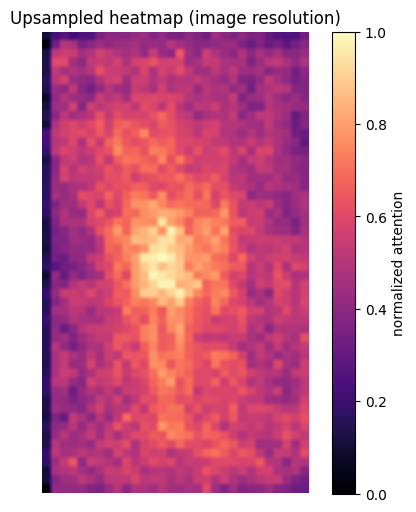

In [23]:
import torch.nn.functional as F

H = 832
W = 480

heatmap_full = torch.tensor(heatmap_latent).unsqueeze(0).unsqueeze(0)
heatmap_up = F.interpolate(
    heatmap_full,
    size=(heatmap_latent.shape[0], H, W),
    mode="trilinear",
    align_corners=False).squeeze(0).squeeze(0)

frame_up = collapse_frames(heatmap_up)
norm = frame_up - frame_up.min()
denom = frame_up.max() - frame_up.min()
if denom > 0:
    norm = norm / denom

plt.figure(figsize=(6, 6))
plt.imshow(norm.numpy(), cmap="magma", vmin=VMIN, vmax=VMAX)
plt.title("Upsampled heatmap (image resolution)")
plt.colorbar(label="normalized attention")
plt.axis("off")
plt.show()
